In [31]:
#hide
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from HierarchicalGeoClustering.TreeClusters import *
from HierarchicalGeoClustering.Clustering import *
from sklearn.preprocessing import StandardScaler
import graph_tool as gt
from graph_tool.all import triangulation, label_components
from scipy.linalg import norm


In [3]:
#### create the clusters
HGC = TreeClusters(4, random_seed= 124)

In [4]:
HGC.print_structure()

Root
Root    
├── Root_l_0_n_0
│   ├── Root_l_0_n_0_l_1_n_0
│   │   └── Root_l_0_n_0_l_1_n_0_l_2_n_0
│   │       ├── Root_l_0_n_0_l_1_n_0_l_2_n_0_l_3_n_0
│   │       └── Root_l_0_n_0_l_1_n_0_l_2_n_0_l_3_n_1
│   ├── Root_l_0_n_0_l_1_n_1
│   ├── Root_l_0_n_0_l_1_n_2
│   │   ├── Root_l_0_n_0_l_1_n_2_l_2_n_0
│   │   ├── Root_l_0_n_0_l_1_n_2_l_2_n_1
│   │   │   ├── Root_l_0_n_0_l_1_n_2_l_2_n_1_l_3_n_0
│   │   │   └── Root_l_0_n_0_l_1_n_2_l_2_n_1_l_3_n_1
│   │   └── Root_l_0_n_0_l_1_n_2_l_2_n_2
│   │       └── Root_l_0_n_0_l_1_n_2_l_2_n_2_l_3_n_0
│   └── Root_l_0_n_0_l_1_n_3
│       ├── Root_l_0_n_0_l_1_n_3_l_2_n_0
│       │   ├── Root_l_0_n_0_l_1_n_3_l_2_n_0_l_3_n_0
│       │   ├── Root_l_0_n_0_l_1_n_3_l_2_n_0_l_3_n_1
│       │   └── Root_l_0_n_0_l_1_n_3_l_2_n_0_l_3_n_2
│       └── Root_l_0_n_0_l_1_n_3_l_2_n_1
│           ├── Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_0
│           └── Root_l_0_n_0_l_1_n_3_l_2_n_1_l_3_n_1
└── Root_l_0_n_1


In [5]:
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:96: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return shapely.ops.cascaded_union(keep_triangles)
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:377: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  points_cluster_o = [p for p in points_cluster if


/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:689: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  x_points_cluster =[j.x for j in cluster_points  ]
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:690: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  y_points_cluster =[j.y for j in cluster_points  ]


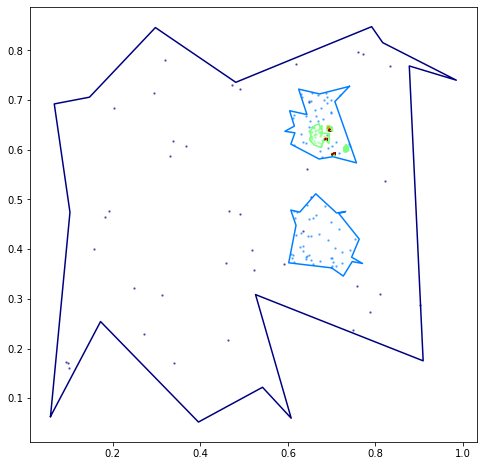

In [6]:
fig, axs = plt.subplots( figsize=(8,8))
HGC.visualize(axs, polygon=True)

In [7]:
### get the delanuay triangulation of the clusters points

original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:1086: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_points =all_points+[i for i in node.get_points(all_tag = iterative )]


In [39]:
def compute_AMOEBA_single(points_array, **kwargs):
    """The function obtains the AMOEBA algorithm on level basis
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    cur_lev = kwargs.get('level', 0)
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    gr, pos_d =triangulation(points_arr, "delaunay")
    dis_d = gr.new_edge_property("double")
    for e in gr.edges():
        dis_d[e] =  norm(pos_d[e.target()].a - pos_d[e.source()].a)
    gr.edge_properties["dis"] = dis_d
    gr.vertex_properties["pos"] = pos_d
    global_edge_mean= np.nan_to_num(gr.edge_properties['dis'].get_array().mean())
    global_edge_std = np.nan_to_num(gr.edge_properties['dis'].get_array().std() ) 
    all_remove_level =[]
    all_keep_level = []
    for vert in gr.vertices():
        local_mean= np.mean([gr.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_edge_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if gr.edge_properties['dis'][ed] > tolerance + global_edge_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = gr.new_edge_property("bool", True)
    gr.edge_properties["level_n_tolerance"] = level_n
    
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        # print(i)
        gr.edge_properties['level_n_tolerance'][i]= False
    # print(all_keep_level_flat)
    for i_k in all_keep_level_flat:
        # print(i_k)
        gr.edge_properties['level_n_tolerance'][i_k]= True
        
    gr.set_edge_filter(prop =  gr.edge_properties['level_n_tolerance'])
    
    
    ##### If the vertex should be keep
    gr.vertex_properties["level_n_r"] = gr.new_vertex_property("bool", False)
    for vert in gr.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['level_n_r'][vert]= True
        else: 
            gr.vertex_properties['level_n_r'][vert]= False
    ##  to not consider the noise points
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(gr)
    gr.set_vertex_filter(None)
    
    gr.vertex_properties["compo_level_n"] = gr.new_vertex_property("int", -1)
    
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    
    compo_level_res_n = gr.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    gr.vertex_properties["compo_level_res_n"] = compo_level_res_n
    
    for vert in gr.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['compo_level_n'][vert]= gr.vertex_properties["compo_level_res_n"][vert] 
        else: 
            # print('No edge')
            gr.vertex_properties['compo_level_n'][vert]= -1
    
    
    ##### Now with the get the vertices in the graph that are in the
    ## connected components   
    dic_bool_arr_n={}
    clusters_result_n= np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a))

    for i in np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a)):
        clus_i_dic = gr.new_vertex_property("int", -1)
        clus_i_dic.a = gr.vertex_properties['compo_level_n'].a == i
        if i == -1:
            gr.vertex_properties["level_n_clus_"+ 'noise']= clus_i_dic
        else:
            gr.vertex_properties["level_n_clus_"+ str(i)] = clus_i_dic
    ################### Here is where the difference should hapen or the create 
    ### a new or use the same graph
    
    return gr

        
    

In [26]:
def build_delaunay_from_arr(points_array, **kwargs):
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    gr, pos = gt.generation.triangulation(points_arr, "delaunay")
    dis = gr.new_edge_property("double")
    dis = gr.new_edge_property("double")
    for e in gr.edges():
        dis[e] =  norm(pos[e.target()].a - pos[e.source()].a)
    gr.edge_properties["dis"] = dis
    gr.vertex_properties["pos"] = pos
    return gr

def compute_AMOEBA_graph_arr(points_array, **kwargs):
    
    """The function obtains the result of the  AMOEBA algorithm as a graph 
    analisys
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    
    
    gr = build_delaunay_from_arr(points_array, **kwargs)
    
    ##### here is the iterative 
    compute_AMOEBA_graph_graph(gr, **kwargs)
    


In [72]:
    
def compute_AMOEBA_graph_graph(graph, **kwargs):
    """The function obtains the result of the  AMOEBA algorithm as a graph 
    analisys
    
    :param graph-tool graph: a Graph class object from graph-tool
    (Obtained from delaunay triangulation or some other triangulation 
    has to be conected in order to make the evaluation on the edges)
    
    :returns: list with numpy arrays for all the clusters obtained
    """

    cur_lev = kwargs.get('level', 1)
    component_to_get_s= kwargs.get('component_to_get_s', '')
    edges_keep_s = kwargs.get('edges_keep_s', '')
    verbose = kwargs.get('verbose', False)
    
    graph.set_edge_filter(None)
    graph.set_vertex_filter(None)
    
    if verbose:
        print('Component to get: ' , component_to_get_s)
        print('Edges to keep: ',  edges_keep_s)
    
    
    ##########
    if component_to_get_s != '':
        component_to_get = graph.vertex_properties[component_to_get_s]
        graph.set_vertex_filter(component_to_get)
    if edges_keep_s != '':
        edges_keep = graph.edge_properties[edges_keep_s]
        graph.set_edge_filter(edges_keep)
    ##### The mean and the standar deviation can not be compute using all the 
    ## edges there for it has to be in a loop
    
    dis_lev = graph.get_edges(eprops=[graph.edge_properties['dis']])[:,2]
    global_mean = dis_lev.mean()
    global_edge_std  = dis_lev.std() 
    all_remove_level = []
    all_keep_level =  []
    if verbose:
        print('The global mean:', global_mean)
        print('The global std:', global_edge_std)
    for vert in graph.vertices():
        
        local_mean= np.mean([graph.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if graph.edge_properties['dis'][ed] > tolerance + global_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = graph.new_edge_property("bool", True)
    graph.edge_properties['l_'+str(cur_lev)+'_tol'] = level_n
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        graph.edge_properties['l_'+str(cur_lev)+'_tol'][i]= False
    for i in all_keep_level_flat:
        graph.edge_properties['l_'+str(cur_lev)+'_tol'][i]= True
        
    graph.set_edge_filter(prop = graph.edge_properties['l_'+str(cur_lev)+'_tol'])
    
    ##### If the vertex should be keep
    graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'] = graph.new_vertex_property("bool", False)
    for vert in graph.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'][vert]= True
        else: 
            graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'][vert]= False
    ##  to not consider the noise points
    graph.set_vertex_filter(prop =  graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(graph)
    graph.set_vertex_filter(None)
    
    
    if verbose:
        print('Set vertex property:' , component_to_get_s +'_compo_l_'+ str(cur_lev))
        print('and filter using such property')
            
    graph.vertex_properties[component_to_get_s +'_compo_l_'+ str(cur_lev)] = graph.new_vertex_property("int", -1)
    
    graph.set_vertex_filter(prop =  graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'])
    
    
    compo_level_res_n = graph.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)+'_res'] = compo_level_res_n
    
    for vert in graph.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            graph.vertex_properties[component_to_get_s +'_compo_l_'+ str(cur_lev)][vert]= graph.vertex_properties[component_to_get_s +'_compo_l_'+str(cur_lev)+'_res' ][vert] 
        else: 
            # print('No edge')
            graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)][vert]= -1
    
    
    ##### Now with the get the vertices in the graph that are in the
    ## connected components   
    dic_bool_arr_n={}
    clusters_result_n= np.nan_to_num(np.unique(graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a))
    if verbose:
        print(clusters_result_n)
        
    for i in np.nan_to_num(np.unique(graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a)):
        clus_i_dic = graph.new_vertex_property("bool", 0)
        clus_i_dic.a = graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a == i
        if verbose:
            print('Level', str(cur_lev)  )
            print('Points in cluster ', str(i), sum(clus_i_dic.a)  )
        if i == -1:
            graph.vertex_properties[component_to_get_s+'_l_'+str(cur_lev)+ '_noise']= clus_i_dic
        else:
            graph.vertex_properties[component_to_get_s+'_l_'+str(cur_lev)+ '_clus_'+ str(i)] = clus_i_dic
    ################### Here is where the difference should hapen or the create 
    ### a new or use the same graph
    
    # return graph




In [ ]:
_compo_l1_res

In [68]:
gra_dela=build_delaunay_from_arr(X_2, scale_points=False)

In [69]:
gra_dela.properties

{('e',
  'dis'): <EdgePropertyMap object with value type 'double', for Graph 0x7f8e707f3d50, at 0x7f8e70749510>,
 ('v',
  'pos'): <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8e707f3d50, at 0x7f8e70749890>}

In [73]:
compute_AMOEBA_graph_graph(gra_dela, level=1, verbose = True)

Component to get:  
Edges to keep:  
The global mean: 0.008959934002089817
The global std: 0.03474156935604138
Set vertex property: _compo_l_1
and filter using such property
[-1  0  1  2  3  4  5  6  7]
Level 1
Points in cluster  -1 35
Level 1
Points in cluster  0 2
Level 1
Points in cluster  1 2
Level 1
Points in cluster  2 30
Level 1
Points in cluster  3 840
Level 1
Points in cluster  4 3
Level 1
Points in cluster  5 2
Level 1
Points in cluster  6 3
Level 1
Points in cluster  7 3


In [83]:
for i in gra_dela.vertex_properties.keys():
    print(i)

pos
l_1_tol_r
_compo_l_1
_compo_l_1_res
_l_1_noise
_l_1_clus_0
_l_1_clus_1
_l_1_clus_2
_l_1_clus_3
_l_1_clus_4
_l_1_clus_5
_l_1_clus_6
_l_1_clus_7


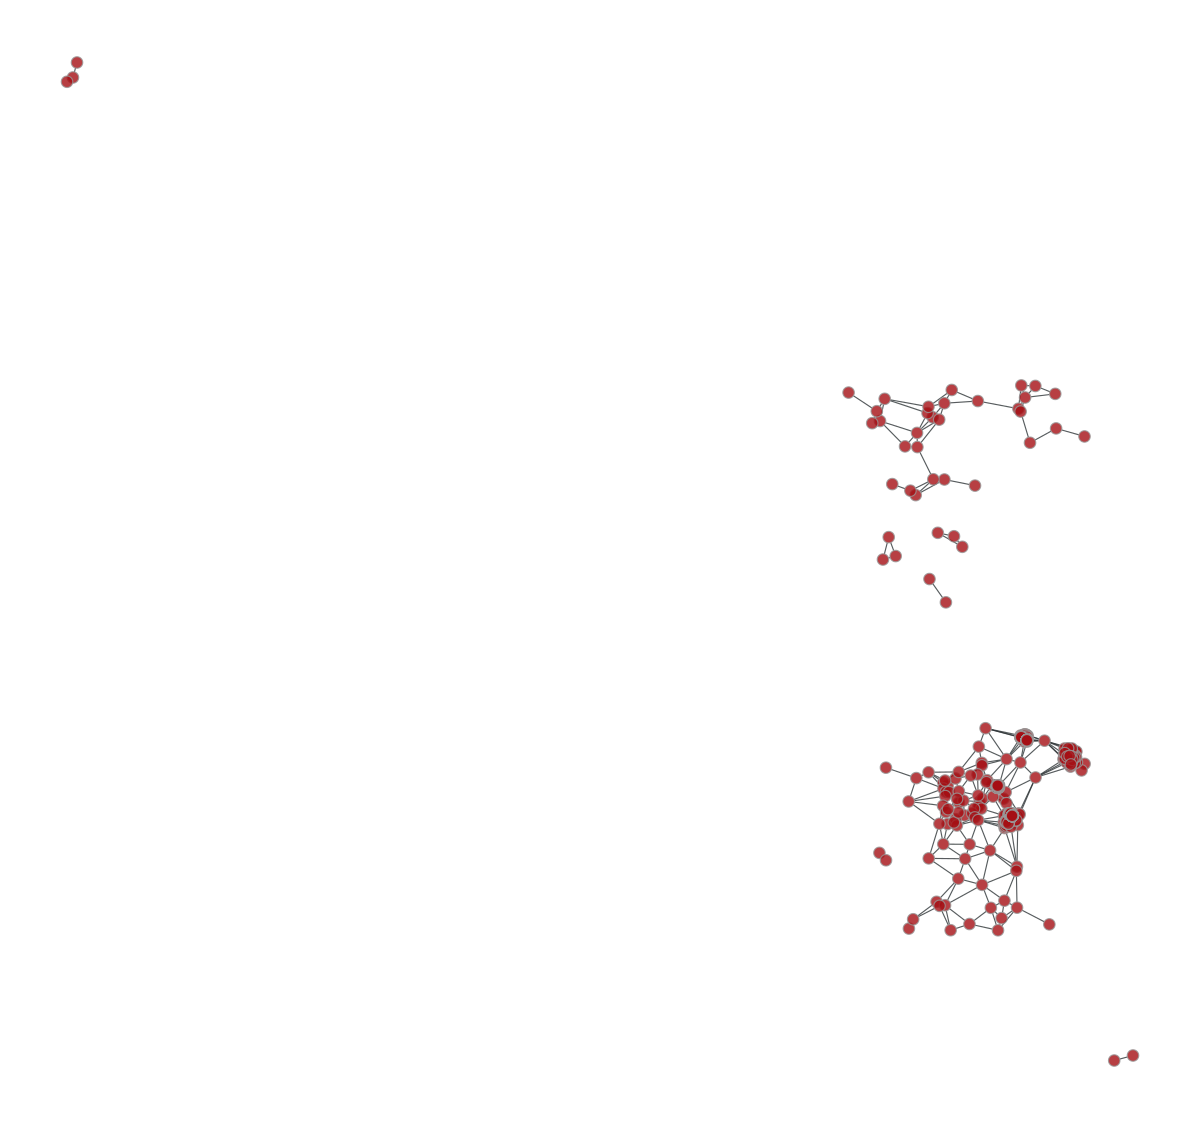

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8e707f3d50, at 0x7f8e70749890>

In [74]:
# g.set_vertex_filter(None) ## Recover the graph
# g.set_edge_filter(None)
gt.draw.graph_draw(gra_dela, pos =gra_dela.vertex_properties['pos'],) 

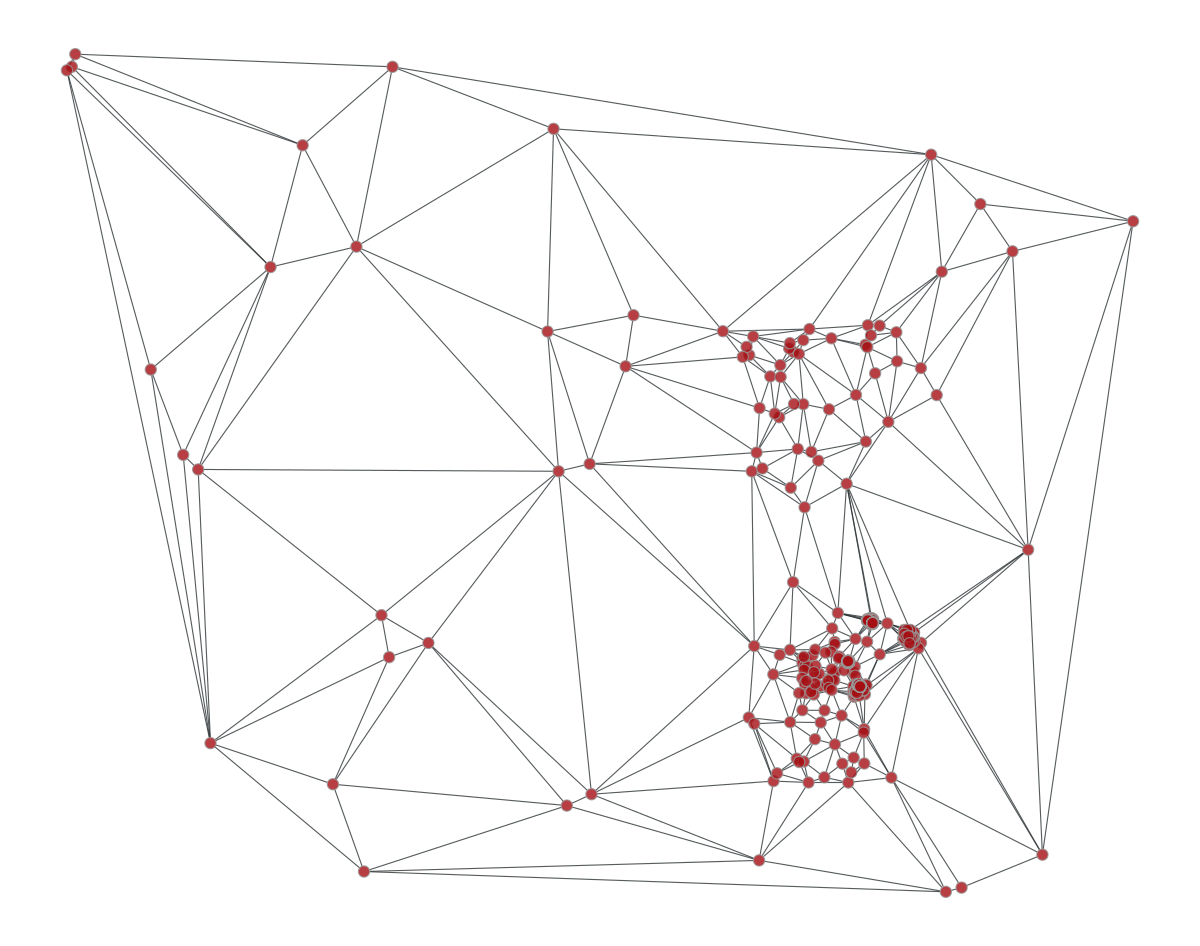

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8e707f3d50, at 0x7f8e70749890>

In [75]:
gra_dela.set_vertex_filter(None) ## Recover the graph
gra_dela.set_edge_filter(None)
gt.draw.graph_draw(gra_dela, pos =gra_dela.vertex_properties['pos'],) 

In [90]:
compute_AMOEBA_graph_graph(gra_dela,
                           level=2,
                           component_to_get_s= '_l_1_clus_3' ,
                           edges_keep_s= 'l_1_tol',
                           verbose = True)

Component to get:  _l_1_clus_3
Edges to keep:  l_1_tol
The global mean: 0.0013887490265728105
The global std: 0.0039441059523315815
Set vertex property: _l_1_clus_3_compo_l_2
and filter using such property
[-1  0  1  2  3  4  5  6  7  8  9 10]
Level 2
Points in cluster  -1 135
Level 2
Points in cluster  0 122
Level 2
Points in cluster  1 41
Level 2
Points in cluster  2 282
Level 2
Points in cluster  3 5
Level 2
Points in cluster  4 2
Level 2
Points in cluster  5 2
Level 2
Points in cluster  6 4
Level 2
Points in cluster  7 2
Level 2
Points in cluster  8 3
Level 2
Points in cluster  9 2
Level 2
Points in cluster  10 320


In [98]:
for i in gra_dela.vertex_properties.keys():
    print(i)

pos
l_1_tol_r
_compo_l_1
_compo_l_1_res
_l_1_noise
_l_1_clus_0
_l_1_clus_1
_l_1_clus_2
_l_1_clus_3
_l_1_clus_4
_l_1_clus_5
_l_1_clus_6
_l_1_clus_7
l_2_tol_r
_l_1_clus_0_compo_l_2
_l_1_clus_0_compo_l_2_res
_l_1_clus_0_l_2_noise
_l_1_clus_0_l_2_clus_0
_l_1_clus_1_compo_l_2
_l_1_clus_1_compo_l_2_res
_l_1_clus_1_l_2_noise
_l_1_clus_1_l_2_clus_0
_l_1_clus_2_compo_l_2
_l_1_clus_2_compo_l_2_res
_l_1_clus_2_l_2_noise
_l_1_clus_2_l_2_clus_0
_l_1_clus_2_l_2_clus_1
_l_1_clus_2_l_2_clus_2
_l_1_clus_2_l_2_clus_3
_l_1_clus_3_compo_l_2
_l_1_clus_3_compo_l_2_res
_l_1_clus_3_l_2_noise
_l_1_clus_3_l_2_clus_0
_l_1_clus_3_l_2_clus_1
_l_1_clus_3_l_2_clus_2
_l_1_clus_3_l_2_clus_3
_l_1_clus_3_l_2_clus_4
_l_1_clus_3_l_2_clus_5
_l_1_clus_3_l_2_clus_6
_l_1_clus_3_l_2_clus_7
_l_1_clus_3_l_2_clus_8
_l_1_clus_3_l_2_clus_9
_l_1_clus_3_l_2_clus_10


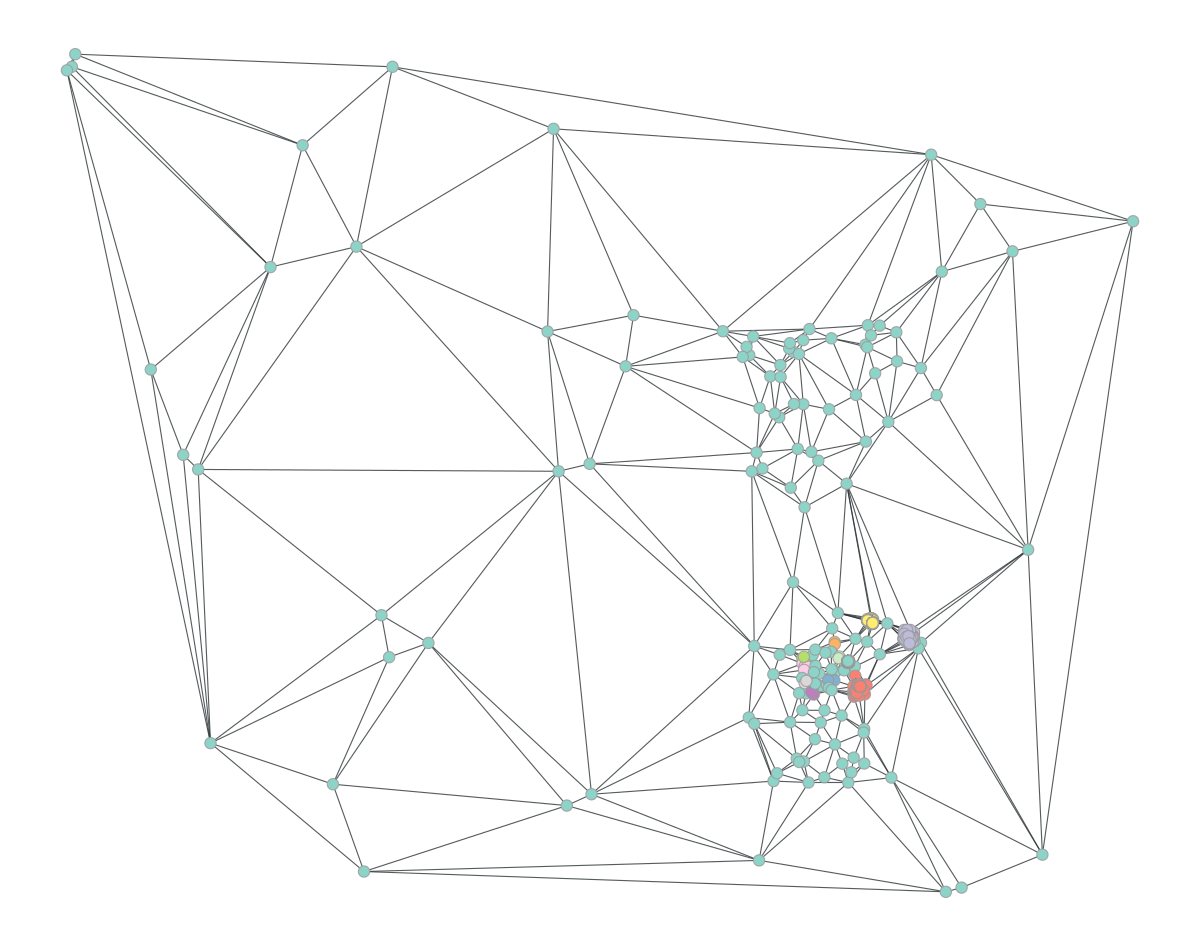

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8e707f3d50, at 0x7f8e70749890>

In [110]:
gra_dela.set_vertex_filter(None) ## Recover the graph
gra_dela.set_edge_filter(None)
gt.draw.graph_draw(gra_dela,
                   pos =gra_dela.vertex_properties['pos'],
                   vertex_fill_color =gra_dela.vertex_properties['_l_1_clus_3_compo_l_2_res'],

                  ) 

Component to get:  _l_1_clus_6
Edges to keep:  l_1_tol
The global mean: 0.011998482891574687
The global std: 0.002650505027248145
Set vertex property: _l_1_clus_6_compo_l_2
and filter using such property
[-1  0]
Level 2
Points in cluster  -1 917
Level 2
Points in cluster  0 3


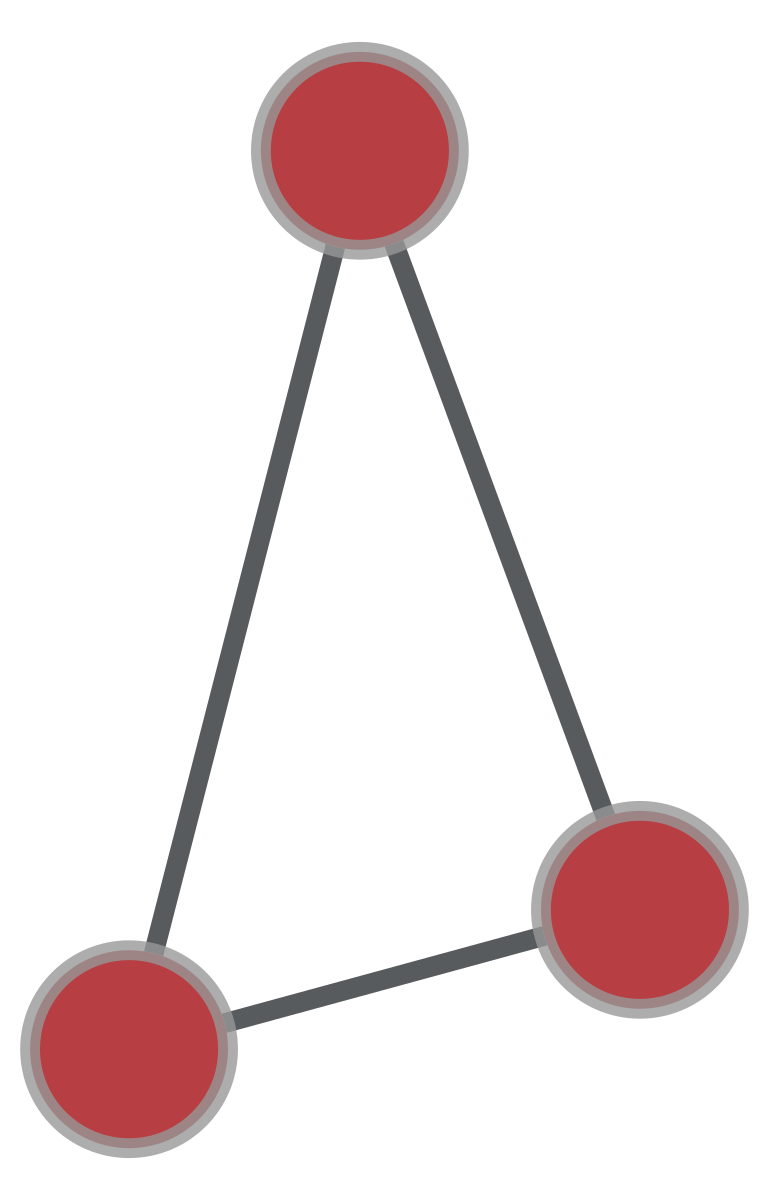

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8e707f3d50, at 0x7f8e70749890>

In [120]:
gra_dela.set_vertex_filter(None) ## Recover the graph
gra_dela.set_edge_filter(None)
compute_AMOEBA_graph_graph(gra_dela,
                           level=2,
                           component_to_get_s= '_l_1_clus_6' ,
                           edges_keep_s= 'l_1_tol',
                           verbose = True)
gt.draw.graph_draw(gra_dela, pos =gra_dela.vertex_properties['pos'],) 

In [46]:
gra_dela.properties

{('e',
  'dis'): <EdgePropertyMap object with value type 'double', for Graph 0x7f8dd18c8550, at 0x7f8dcfd67810>,
 ('v',
  'pos'): <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8dd18c8550, at 0x7f8e70e786d0>,
 ('e',
  'level_1_tolerance'): <EdgePropertyMap object with value type 'bool', for Graph 0x7f8dd18c8550, at 0x7f8e709aa0d0>,
 ('v',
  'level_1_tolerance_r'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f8dd18c8550, at 0x7f8e70b23b50>,
 ('v',
  '_compo_level_1'): <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f8dd18c8550, at 0x7f8e70a5ea90>,
 ('v',
  '_compo_level_res_1'): <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f8dd18c8550, at 0x7f8e70a5e910>,
 ('v',
  '_level_1_noise'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f8dd18c8550, at 0x7f8dcf2cf590>,
 ('v',
  '_level_1_clus_0'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f8dd18c8550, at 0x7f8e709aa850>,
 ('